<a href="https://colab.research.google.com/github/antim9608/Data-Science-III-NLP-Deep-Learning-aplicado-a-Ciencia-de-Datos/blob/main/Primera_entrega_NMJ_Data_science_III_NPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [ ]:
df.shape

(6335, 4)

In [ ]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [ ]:
df = df.set_index('Unnamed: 0')

In [ ]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# Contar cuantas noticias reales y fakes hay en el dataset
pd.value_counts(df['sentimiento'])

<ipython-input-12-91721e6a8015>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentimiento'])


,count
sentimiento,
REAL,3171
FAKE,3164


In [ ]:
# Está balanceado? Cómo lo arreglarías sino?

A partir del conteo realizado se observa que el modelo en genera está balanceado. Se reconfirma revisando las proporciones y con una pequeña gráfica que me muestre esta distribución:

sentimiento
REAL    50.055249
FAKE    49.944751
Name: count, dtype: float64


<ipython-input-17-104cbc36b6b9>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  x = (pd.value_counts(df['sentimiento'])/df.shape[0])*100


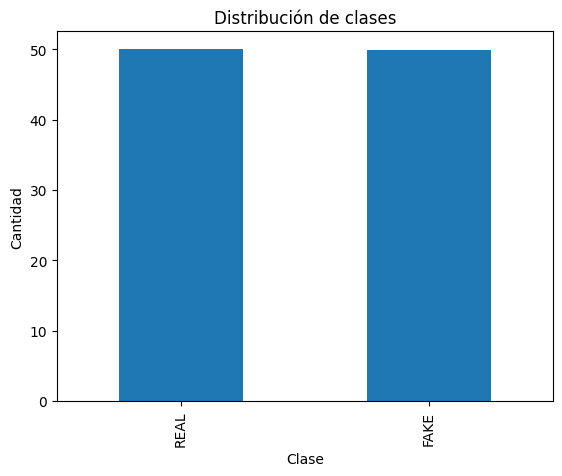

In [ ]:
x = (pd.value_counts(df['sentimiento'])/df.shape[0])*100
print(x)

x.plot(kind='bar')
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

En caso de que estuviera desbalanceado, para no aumentar el tamaño del dataset y hacer más pesado el procesamiento, en este caso preferiría usar un muestreo que me traiga el mismo número de elementos de cada categoría de sentimiento.

In [ ]:
# Dimensiona el dataset
df.shape

(6335, 3)

Una vez identificado el index, se encuentran tres variables (title, texto y sentimiento) para 6335 filas de información.

In [ ]:
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

No tengo variables numéricas, así que no puedo sacar promedios, medianas, moda y demás estadísticas que usualmente se generan para hacer un análisis descriptivo del dataset. Ahora sólo se tienen textos que a priori no me dicen mucho y debo identificar los criterios para poder analizar los datos.

In [ ]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
df_cortado_1 = df.sample(n=1000, random_state=42)
df_cortado_1.shape

(1000, 3)

Se seleccionan 1000 datos aleatorios para tratar de garantizar la independencia de los valores capturados y que colab lo corra sin problema

sentimiento
REAL    51.3
FAKE    48.7
Name: count, dtype: float64


<ipython-input-27-ae835117e504>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_cortado_1['sentimiento'])
<ipython-input-27-ae835117e504>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y = (pd.value_counts(df_cortado_1['sentimiento'])/df_cortado_1.shape[0])*100


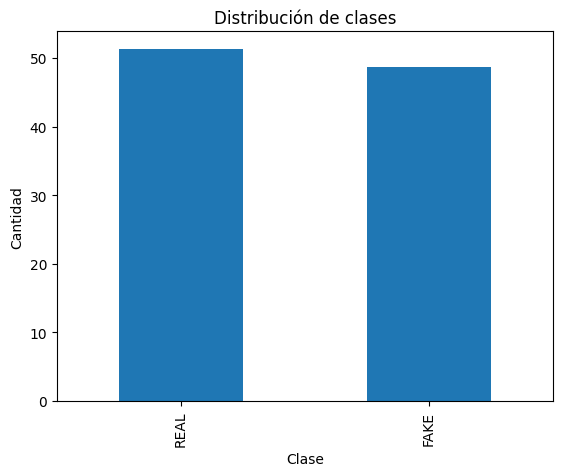

In [ ]:
# Las clases quedaron balanceadas?
pd.value_counts(df_cortado_1['sentimiento'])
y = (pd.value_counts(df_cortado_1['sentimiento'])/df_cortado_1.shape[0])*100
print(y)

y.plot(kind='bar')
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

El corte muestra un leve desbalance, un poco mayor al que pesentábamos con antelación. Como queremos que el análisis de detección de fake news sea lo más preciso posible intentaremos un nuevo corte asegurándonos de que quede balanceado:

In [ ]:
clases = df['sentimiento'].value_counts()
num_clases = len(clases)
df_balanceado = []
for clase in clases.index:
    df_clase = df[df['sentimiento'] == clase]
    df_clase_muestra = df_clase.sample(n=500, random_state=42)
    df_balanceado.append(df_clase_muestra)

df_balanceado = pd.concat(df_balanceado)
print(df_balanceado['sentimiento'].value_counts())

sentimiento
REAL    500
FAKE    500
Name: count, dtype: int64


Ahora ya tenemos exactamente la misma proporción de datos aleatorios para los datos que inicialmente fueron seleccionados como Fake y Real

In [ ]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
df_balanceado['sentimiento'] = df_balanceado['sentimiento'].replace({'FAKE': 0, 'REAL': 1})

df_balanceado.sentimiento.unique()

<ipython-input-31-488ee573190e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_balanceado['sentimiento'] = df_balanceado['sentimiento'].replace({'FAKE': 0, 'REAL': 1})


array([1, 0])

In [ ]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

In [ ]:
# Aplicar preprocesamiento

df_balanceado['texto_procesado'] = df_balanceado['texto'].apply(preprocesar_texto)

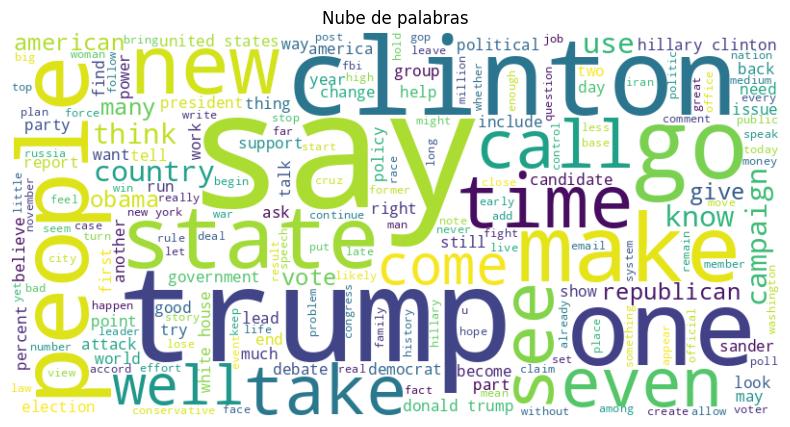

In [ ]:
# Visualizar nube de palabras completando la secuencia de creación
text_combined = " ".join(df_balanceado['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
    N-gram  Frecuencia
0      say        4912
1    trump        3747
2  clinton        3024
3    state        2213
4    would        2198
5      one        1906
6   people        1795
7     year        1636
8     make        1608
9      new        1590


<ipython-input-37-fa62ec4b6382>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


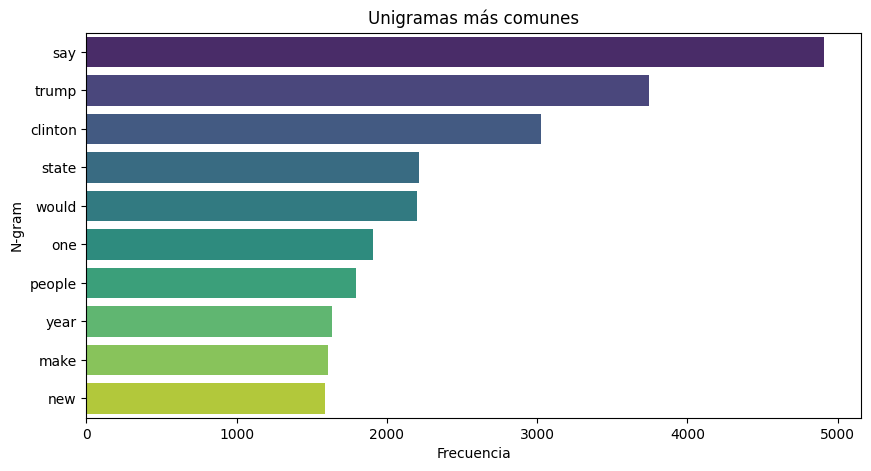


Bigramas más comunes:
             N-gram  Frecuencia
0   hillary clinton         693
1      donald trump         617
2     united states         468
3       white house         442
4          new york         416
5         trump say         227
6   secretary state         216
7   president obama         215
8     supreme court         191
9  state department         190


<ipython-input-37-fa62ec4b6382>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


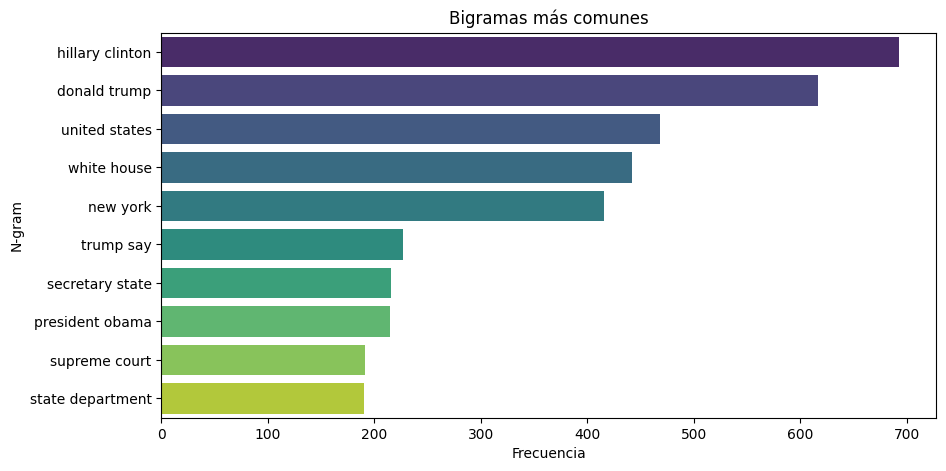


Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         132
1             president barack obama          70
2                     case case case          64
3                       sen ted cruz          45
4            president united states          44
5             former secretary state          43
6               director james comey          42
7  republican presidential candidate          40
8                 fbi director james          39
9                    sen marco rubio          39


<ipython-input-37-fa62ec4b6382>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


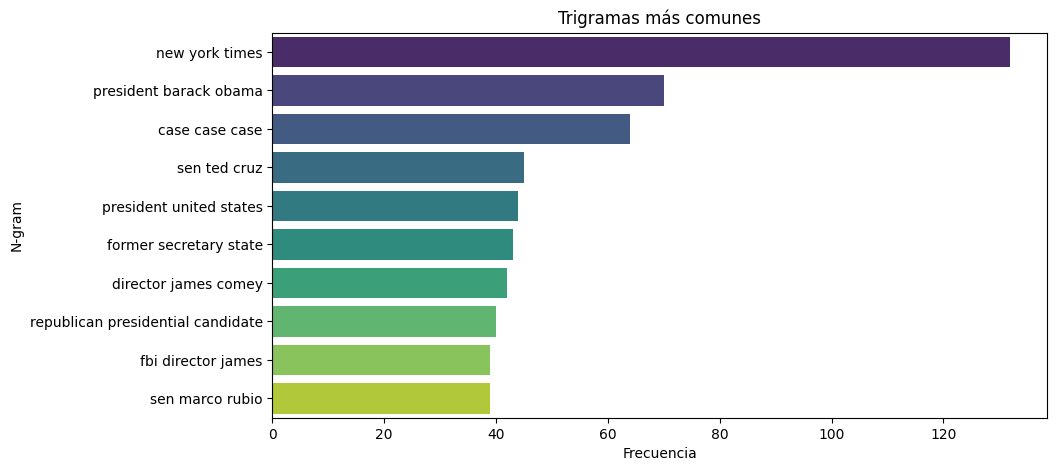

In [ ]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_balanceado['texto_procesado'], 1)
bigrams = get_top_ngrams(df_balanceado['texto_procesado'], 2)
trigrams = get_top_ngrams(df_balanceado['texto_procesado'], 3)


print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

In [ ]:
# Separar datos en entrenamiento y prueba
X = df_balanceado['texto_procesado']
y = df_balanceado['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Predicciones
y_pred = pipeline.predict(X_test)

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.695
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       104
           1       0.61      1.00      0.76        96

    accuracy                           0.69       200
   macro avg       0.81      0.71      0.67       200
weighted avg       0.81      0.69      0.67       200



In [ ]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [ ]:
y_pred2=pac.predict(tfidf_test)

In [ ]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.845
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       104
           1       0.82      0.88      0.84        96

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200

